# Deep Hedging of Green PPAs

## Imports

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../../..')
sys.path.insert(0,'..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
#import seaborn
#seaborn.set_style('whitegrid')
#seaborn.reset_orig() #uncomment to get seaborn styles

#import pprint
#import deepdiff
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, LinearDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer, DeepHedgeModel


import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

import nb_tools
nb_tools.set_repo('.')
from nb_tools import repo

for k,v in repo.results.items():
    v['val_date'] = dt.datetime.fromisoformat(v['val_date'])
    v['ppa_spec']['schedule'] = [dt.datetime.fromisoformat(k) for k in v['ppa_spec']['schedule']]

/home/doeltz/doeltz/development/RiVaPy2/sandbox/green_ppa/utility_vs_shortfall_OTM/../../../rivapy/__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')
2024-09-04 13:51:51.151459: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 13:51:51.182081: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 13:51:51.182618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 13:51:55.853315:

## HiPlot Overview

In [3]:
repo.plot_hiplot(conditions = [
    #('pricing_param.nb_neurons', 32),
    #('pricing_param.loss', 'expected_shortfall'),
    #('pricing_param.epochs', 400),
    #('ppa_spec.max_capacity',(0.0,100.0)),
    ])

<IPython.core.display.Javascript object>

## Experiment Definition

In [5]:
experiment = {
    "name": "5% CVaR with OTM Green PPA",
    "description": "",
    "models":[('804790197c6877907bd0027fec0b132b142abce2','5% CVaR'),
             
            ]
}
result_dir = './figures/'

In [6]:
sim_results, forecast_points, hedge_models, specs, paths, pnl, deltas = nb_tools.setup(experiment)

2024-09-04 13:53:25.461015: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-04 13:53:25.461037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: meray
2024-09-04 13:53:25.461041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: meray
2024-09-04 13:53:25.461093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.90.7
2024-09-04 13:53:25.461106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.90.7
2024-09-04 13:53:25.461110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.90.7


1.2
3125/3125 [==============================] - 5s 1ms/step


In [7]:
# Adjustment according to special problem
pnl_ = {k: v for k,v in pnl.items() if 'hedge' not in k}
pnl_['volume hedge'] = pnl['volume_hedge, 5% CVaR']
pnl_['no hedge'] = pnl['no_hedge, 5% CVaR']
pnl = pnl_

## Statistics

In [13]:
df = nb_tools.compute_statistics(pnl)
pd.options.display.float_format = '{:,.4f}'.format
df

,mean,var,p-skewness,5% ES,30% ES,"utility, 0.05","utility, 0.15"
name,,,,,,,
5% CVaR,-10.3899,0.5642,0.2584,-11.4816,-10.9927,1.6818,4.7685
volume hedge,-10.3907,0.9808,-0.6580,-13.0386,-11.5900,1.6833,4.8073
no hedge,-10.4003,6.0414,-0.1519,-23.6935,-17.5860,1.7628,7.4252


## PnL Distribution

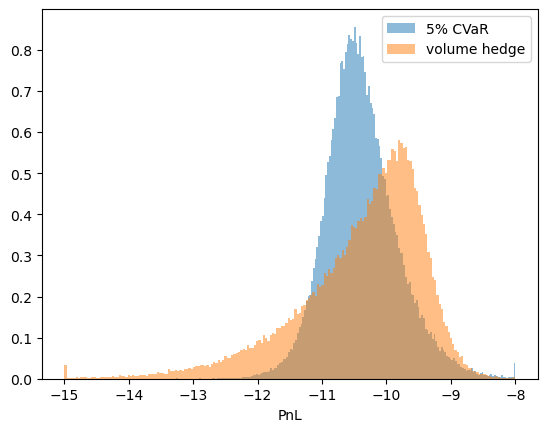

In [12]:
for k,v in pnl.items():
    if (k=='no hedge') or ('EU' in k) or ('30%' in k):
        continue
    plt.hist(np.clip(100*v, -15,-8), bins=200, label=k, density=True, alpha=0.5)
plt.legend()
plt.xlabel('PnL')
plt.savefig(result_dir+'pnl_hist.png', dpi=500)

## Delta - Timeslice

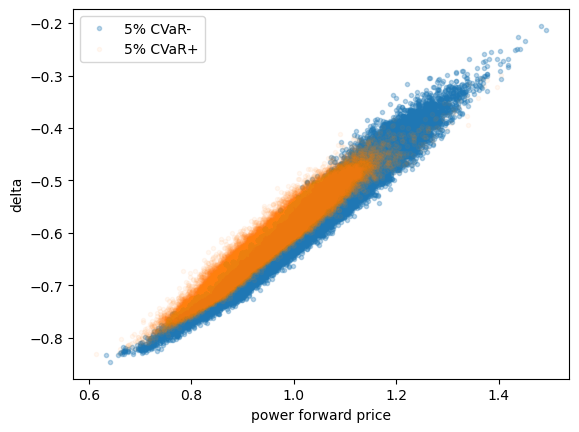

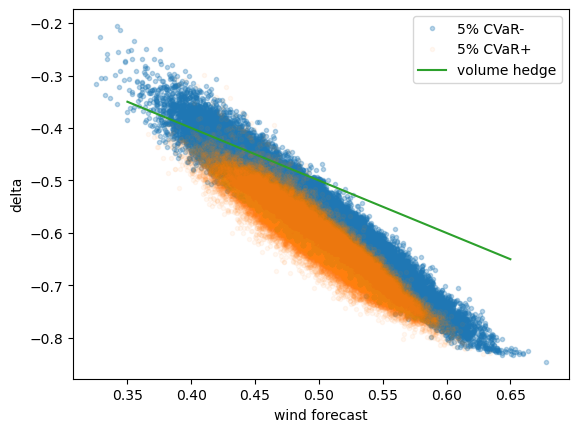

In [14]:
t = -2

for k,v in hedge_models.items():
    if (k=='no hedge') or ('EU' in k) or ('30%' in k):
        continue
    v = paths[k]['Power_Germany_FWD0']
    pnl_minus = pnl[k]-pnl[k].mean()<0
    #plt.plot(v[t,:], deltas[k][t,:].reshape((-1,)),'.', label=k, alpha=0.3)
    plt.plot(v[t,pnl_minus], deltas[k][t,pnl_minus],'.', label=k+'-', alpha=0.3)
    plt.plot(v[t,~pnl_minus], deltas[k][t,~pnl_minus],'.', label=k+'+', alpha=0.05)
plt.xlabel('power forward price')
plt.ylabel('delta')
plt.legend()
plt.savefig(result_dir+'delta_vs_power.png', dpi=500)
plt.figure()
for k,v in hedge_models.items():
    if (k=='no hedge') or ('EU' in k) or ('30%' in k):
        continue
    v = paths[k]['Onshore_FWD0']
    pnl_minus = pnl[k]-pnl[k].mean()<0
    plt.plot(v[t,pnl_minus], deltas[k][t,pnl_minus],'.', label=k+'-', alpha=0.3)

    plt.plot(v[t,~pnl_minus], deltas[k][t,~pnl_minus],'.', label=k+'+', alpha=0.05)
plt.plot([0.35,0.65], [-0.35,-0.65],'-', label='volume hedge', alpha=1.0)
plt.xlabel('wind forecast')
plt.ylabel('delta')
plt.legend()
plt.savefig(result_dir+'delta_vs_wind.png', dpi=500)

## Delta-Scatter Plot

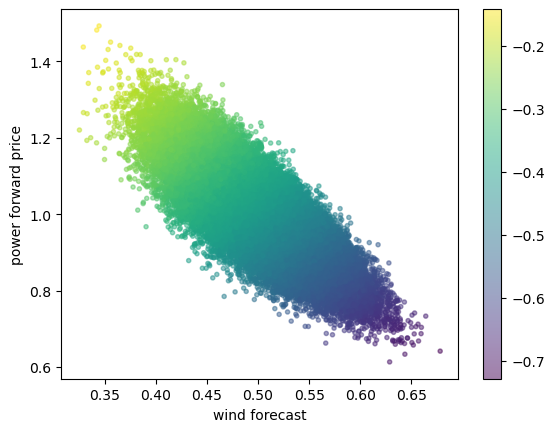

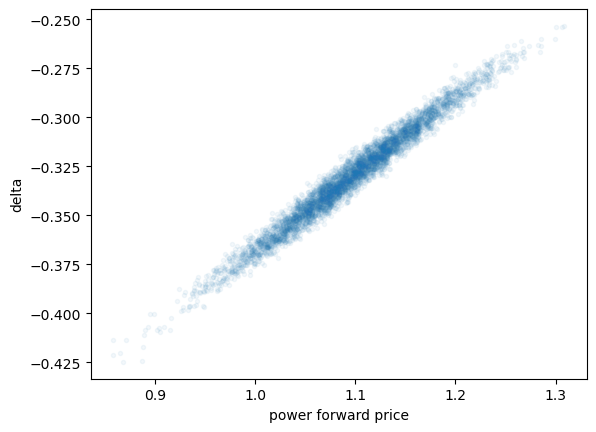

In [25]:
t=-2
for k,v in hedge_models.items():
    if (k=='no hedge') or ('EU' in k) or ('30%' in k):
        continue
    x = paths[k]['Onshore_FWD0'][t,:]
    y = paths[k]['Power_Germany_FWD0'][t,:]
    c = deltas[k][t,:]
    plt.scatter(x,y,c=c,marker='.', alpha=0.5)
    plt.colorbar()
    plt.xlabel('wind forecast')
    plt.ylabel('power forward price');

plt.figure()
for k,v in hedge_models.items():
    if (k=='no hedge') or ('EU' in k) or ('30%' in k):
        continue
    x = paths[k]['Onshore_FWD0'][t,:]
    x=(x<0.455)&(x>0.445)
    y = paths[k]['Power_Germany_FWD0'][t,x]
    c = deltas[k][t,x]
    plt.plot(y,c, '.', alpha=0.05)
plt.xlabel('power forward price')
plt.ylabel('delta');

## Delta - Path

0.09711767856432513


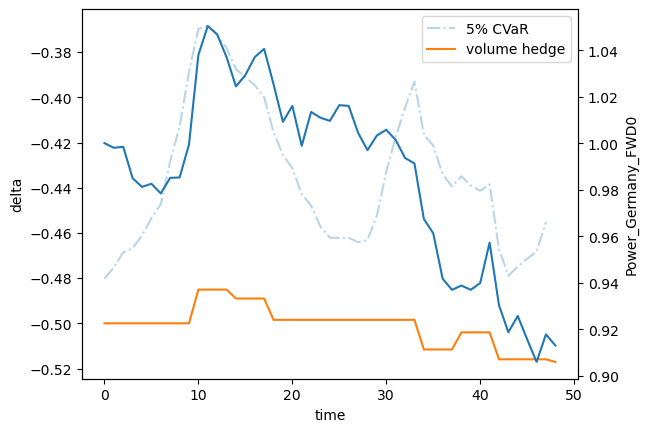

In [14]:
n_sim = 5 # definition of the path that is used
### the following code searches for the path with the largest pnl differencebetween two models
model_1 = '5% CVaR'
model_2 = '30% CVaR'
n_sim = np.argmin(pnl[model_1])#-pnl[model_2]))
print(pnl[model_1][n_sim])

for k,v in hedge_models.items():
    if (k=='no hedge') or ('EU' in k) or ('30%' in k):
        continue
    plt.plot(deltas[k][:,n_sim],'-.', label=k, alpha=0.3)

plt.xlabel('time')
plt.ylabel('delta')
wind = next(iter(paths.values()))['Onshore_FWD0'] 
plt.plot(-wind[:,n_sim],'-', label='volume hedge', )
plt.legend();
power = next(iter(paths.values()))['Power_Germany_FWD0']
ax2 = plt.twinx() 
ax2.plot(power[:,n_sim],'-', label='Power_Germany_FWD0', )
ax2.set_ylabel('Power_Germany_FWD0')
plt.savefig(result_dir+'deltapath.png', dpi=500)

0.019391553819629703


Text(0, 0.5, 'Power_Germany_FWD0')

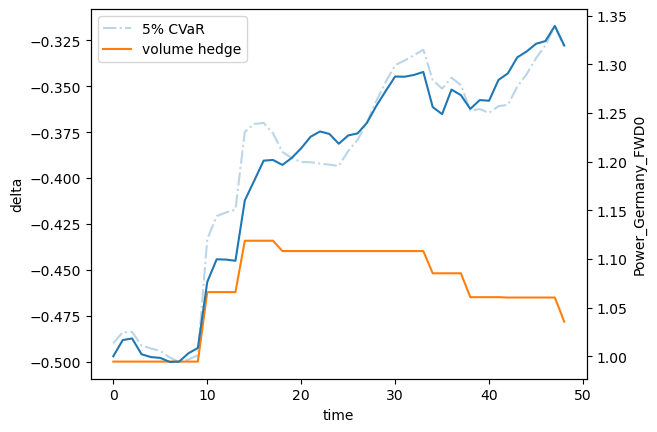

In [35]:
n_sim = 5 # definition of the path that is used
### the following code searches for the path with the largest pnl differencebetween two models
model_1 = '5% CVaR'
model_2 = '30% CVaR'
n_sim = np.argmax(pnl[model_1])#-pnl[model_2]))
print(pnl[model_1][n_sim])

for k,v in hedge_models.items():
    if (k=='no hedge') or ('EU' in k) or ('30%' in k):
        continue
    plt.plot(deltas[k][:,n_sim],'-.', label=k, alpha=0.3)

plt.xlabel('time')
plt.ylabel('delta')
wind = next(iter(paths.values()))['Onshore_FWD0'] 
plt.plot(-wind[:,n_sim],'-', label='volume hedge', )
plt.legend();
power = next(iter(paths.values()))['Power_Germany_FWD0']
ax2 = plt.twinx() 
ax2.plot(power[:,n_sim],'-', label='Power_Germany_FWD0', )
ax2.set_ylabel('Power_Germany_FWD0')
#ax2.axhline(1.0)
#plt.legend();

## Average Delta

Text(0, 0.5, 'delta')

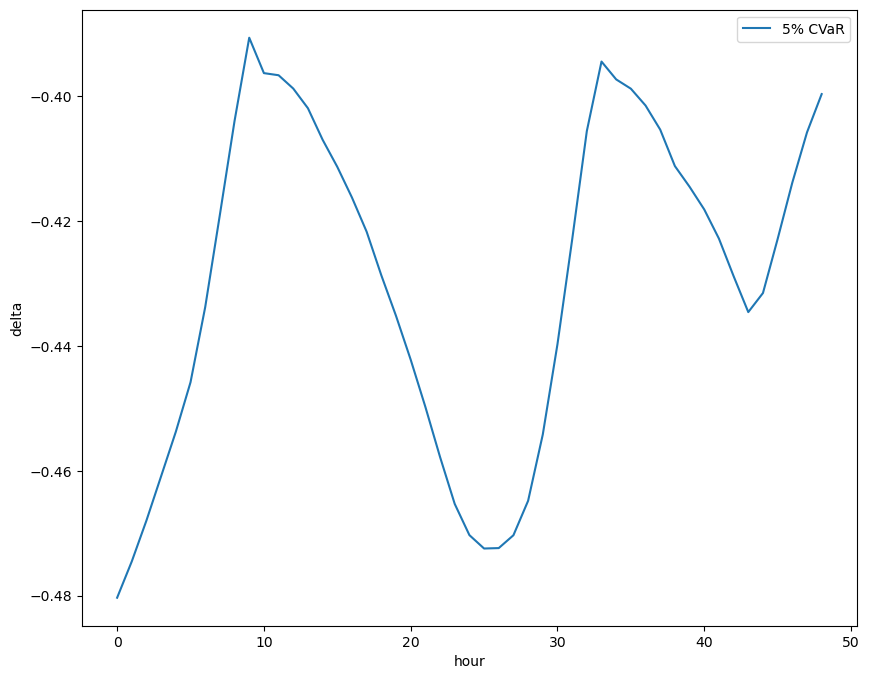

In [26]:
plt.figure(figsize=(10,8))
for k,v in deltas.items():
    plt.plot(v.mean(axis=1), label = k)
plt.legend()
plt.xlabel('hour')
plt.ylabel('delta')

# END

In [ ]:
This is the end to stop notebook execution with error to avoid execution of snippet cells below.

SyntaxError: invalid syntax (410739213.py, line 1)

# Snippets

## Utility Vs ES

In [ ]:
experiment = 'symmetric' #'ES vs utility' #'varying_regularization_forecast_0.5' #'varying_regularization' expected_shortfall
ref_keys = experiments[experiment]['ref_keys']

labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results, forecast_points, hedge_models, specs, paths, pnl = setup(ref_keys, ref_key_volume_hedge=labels_T['0.0'])

#sim_results, forecast_points, hedge_models, specs, paths, pnl = setup(['35ada79703bc4f3c58b0233fcba96bbffb3f73e6'], ref_key_volume_hedge='35ada79703bc4f3c58b0233fcba96bbffb3f73e6')


simulate paths
[datetime.datetime(2023, 1, 3, 0, 0)]
[datetime.datetime(2023, 1, 3, 0, 0)]
[datetime.datetime(2023, 1, 3, 0, 0)]
load models and specs


2024-04-22 15:28:51.718014: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-22 15:28:51.718059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: meray
2024-04-22 15:28:51.718070: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: meray
2024-04-22 15:28:51.718187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 545.29.6
2024-04-22 15:28:51.718221: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 545.29.6
2024-04-22 15:28:51.718232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 545.29.6
2024-04-22 15:28:51.726867: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfor

compute pnl
1.0
1.0
1.0


### Simulation Results

{'Onshore_FWD0', 'Offshore_FWD0', 'Wind_Germany_FWD0', 'Power_Germany_FWD0'}
0.0014711537364851528 0.0018487719972381427


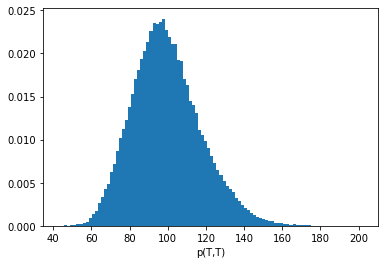

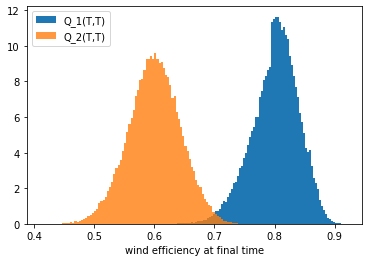

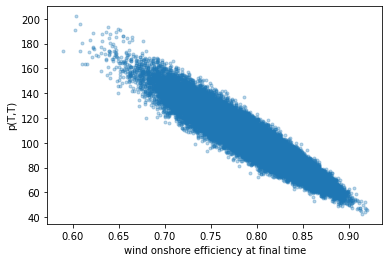

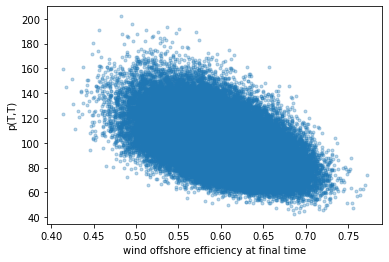

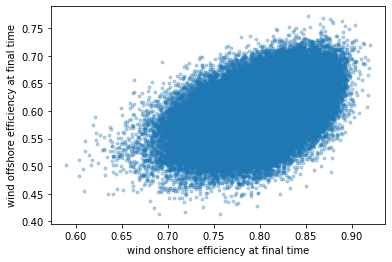

In [ ]:
depp = sim_results['5ee5a389befed1ec47516fa929e5489e89f44480']
print(depp.keys())
power = depp.get('Power_Germany_FWD0')
wind_onshore = depp.get('Onshore_FWD0')
wind_offshore = depp.get('Offshore_FWD0')

plt.hist(100*power[-1,:], bins=100, density=True)
plt.xlabel('p(T,T)')
#plt.ylabel('probability')
plt.savefig('results/utility_vs_es/power_hist.png', dpi=800)

plt.figure()
plt.hist(wind_onshore[-1,:], bins=100,density=True, label='Q_1(T,T)')
plt.hist(wind_offshore[-1,:], bins=100,density=True, label='Q_2(T,T)', alpha=0.8)
plt.xlabel('wind efficiency at final time')
#plt.ylabel('probability')
plt.legend()
plt.savefig('results/utility_vs_es/wind.png', dpi=800)

plt.figure()
plt.plot(wind_onshore[-1,:], 100*power[-1,:],'.', alpha=0.3)
plt.xlabel('wind onshore efficiency at final time')
plt.ylabel('p(T,T)')
plt.savefig('results/utility_vs_es/wind_onshore_vs_power.png', dpi=800)

plt.figure()
plt.plot(wind_offshore[-1,:], 100*power[-1,:],'.', alpha=0.3)
plt.xlabel('wind offshore efficiency at final time')
plt.ylabel('p(T,T)')
plt.savefig('results/utility_vs_es/wind_offshore_vs_power.png', dpi=800)

plt.figure()
plt.plot(wind_onshore[-1,:], wind_offshore[-1,:],'.', alpha=0.3)
plt.xlabel('wind onshore efficiency at final time')
plt.ylabel('wind offshore efficiency at final time')
plt.savefig('results/utility_vs_es/wind_offshore_vs_wind_offshore.png', dpi=800)

print(wind_onshore[-1,:].var(), wind_offshore[-1,:].var())

### PnL Distributions

In [ ]:
experiment = 'onshore_forecast' #'ES vs utility' #'varying_regularization_forecast_0.5' #'varying_regularization' expected_shortfall
ref_keys = experiments[experiment]['ref_keys']

labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results, forecast_points, hedge_models, specs, paths, pnl = setup(ref_keys, ref_key_volume_hedge=[labels_T[k] for k in ['0.2', '0.5', '0.8']])

simulate paths
[datetime.datetime(2023, 1, 3, 0, 0)]
[datetime.datetime(2023, 1, 3, 0, 0)]
[datetime.datetime(2023, 1, 3, 0, 0)]
load models and specs
compute pnl
1.0
3125/3125 [==============================] - 15s 4ms/step
1.0
3125/3125 [==============================] - 16s 4ms/step
1.0
3125/3125 [==============================] - 16s 4ms/step


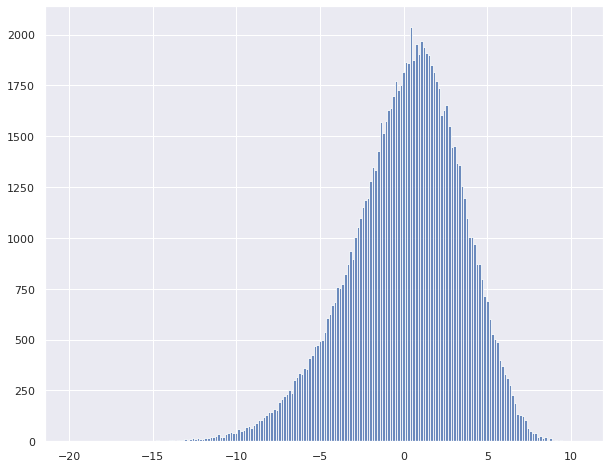

In [ ]:
plt.figure(figsize=(10,8))
key = '5ee5a389befed1ec47516fa929e5489e89f44480'
#seaborn.set()
#seaborn.histplot(np.clip(10_000*pnl[key], 100*-3,100), bins=200, label='Volume Hedge', alpha=0.6)#, kde=True,stat='probability')
plt.hist(np.clip(pnl[key], 100*-3,100), bins=200, label='Volume Hedge', alpha=0.8)
#key = '5%-ES'
#key = labels_T[key]
#plt.hist(np.clip(10_000*pnl[key], 100*-3,1), bins=200, label='5% ES', density=True, alpha=0.8);
if False:
    key = '20%-ES'
    key = labels_T[key]
    seaborn.histplot(np.clip(10_000*pnl[key], 100*-3,100), bins=200, label='Deep Hedging',alpha=0.3, kde=True, color='orange',stat='probability')
    #plt.hist(np.clip(10_000*pnl[key], 100*-3,100), bins=200, label='Deep Hedging',alpha=0.8, kde=True)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Profit and Loss', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.savefig('results/e_world/es_hist.png', dpi=3200)


In [ ]:
als Auswertung: mittelwert aller hedges über die Pfade->Annahme: Jede Strategie hat im Mittel die gleichen Werte

In [ ]:
v_=pnl[key]
tmp = np.percentile(v_, 20)
tmp = v_[v_<tmp].mean()
print(tmp)

-4.891091113853455


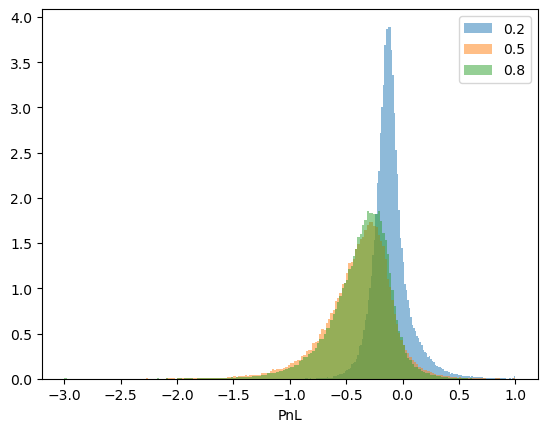

In [ ]:
#key = 'volume_hedge'
#plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='volume hedge', density=True, alpha=0.5)
key = '0.2'
key = labels_T[key]
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='0.2', density=True, alpha=0.5);
key = '0.5'
key = labels_T[key]
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='0.5', density=True, alpha=0.5)
key = '0.8'
key = labels_T[key]
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='0.8', density=True, alpha=0.5)
plt.legend()
plt.xlabel('PnL')
#plt.savefig('results/utility_vs_es/es_hist.png', dpi=800)

if False:
    plt.figure()
    key = 'utility, $\\lambda$=5'
    key = labels_T[key]
    plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='$\\lambda$=0.05', density=True, alpha=0.5);
    key = 'volume_hedge'
    plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='volume hedge', density=True, alpha=0.5)
    key = 'utility, $\\lambda$=10'
    key = labels_T[key]
    plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='$\\lambda$=0.1', density=True, alpha=0.5)
    plt.legend();
    plt.xlabel('PnL')
    plt.savefig('results/utility_vs_es/utility_hist.png', dpi=800)
    plt.figure()
    #key = 'volume_hedge'
    key = 'utility, $\\lambda$=10'
    key = labels_T[key]
    plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='$\\lambda$=0.1', density=True, alpha=0.5);
    #key = 'no_hedge'
    key='20%-ES'
    key = labels_T[key]
    plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='20% ES', density=True, alpha=0.5)
    plt.legend()
    plt.savefig('results/utility_vs_es/utility_vs_es_hist.png', dpi=800)
    plt.xlabel('PnL');

Text(0, 0.5, 'PnL 5% ES')

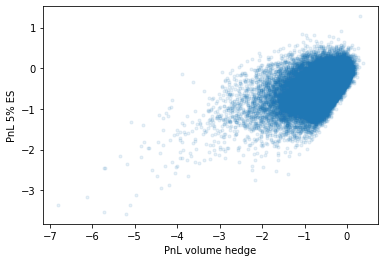

In [ ]:
key = 'volume_hedge'
pnl1 = 100*pnl[key]
key = '5%-ES'
key = labels_T[key]
pnl2 = 100*pnl[key]
plt.plot(pnl1,pnl2,'.', alpha=0.1)
plt.xlabel('PnL volume hedge')
plt.ylabel('PnL 5% ES')
#plt.xlim(-7,0.5)
#plt.ylim(-7,0.5);

In [ ]:
(paths[labels_T['5%-ES']]['Power_Germany_FWD0']-paths[labels_T['20%-ES']]['Power_Germany_FWD0']).mean()

0.0

### PnL Statistics

In [ ]:
df = compute_statistics(pnl, labels)
#df=df.reset_index()
pd.options.display.float_format = '{:,.4f}'.format
df
#print(df.to_latex())

,mean,var,p-skewness,5% ES,20% ES,"utility, 0.05","utility, 0.1"
name,,,,,,,
"volume_hedge, 6eeb759bde89e8ccb52dbb87df46fbd309230c3e",-0.1046,0.1637,-0.6144,-0.5863,-0.3521,1.0053,1.0107
"no_hedge, 6eeb759bde89e8ccb52dbb87df46fbd309230c3e",-0.0898,1.4118,-0.2082,-3.3722,-2.1654,1.0070,1.0193
"volume_hedge, e228461c54178380bddfa445f4b40f2b0b8326a6",-0.3903,0.3979,-0.8189,-1.6025,-1.0146,1.0199,1.0407
"no_hedge, e228461c54178380bddfa445f4b40f2b0b8326a6",-0.3999,5.2794,-0.1609,-12.0629,-8.0858,1.0573,1.2049
"volume_hedge, ed20671996aa4d5f27ebba35925c0ce204aeb538",-0.3680,0.3805,-0.8805,-1.5654,-0.9517,1.0188,1.0383
"no_hedge, ed20671996aa4d5f27ebba35925c0ce204aeb538",-0.6135,11.2505,0.0977,-22.8757,-15.9479,1.2020,1.9301
0.5,-0.3906,0.3043,-0.3975,-1.1842,-0.8427,1.0198,1.0403
0.8,-0.3711,0.2771,-0.4420,-1.1063,-0.7867,1.0188,1.0382
0.2,-0.1059,0.1658,0.2881,-0.4226,-0.3016,1.0053,1.0108


In [ ]:
for k,v in labels_T.items():
    print(k,v)

0.5 e228461c54178380bddfa445f4b40f2b0b8326a6
0.8 ed20671996aa4d5f27ebba35925c0ce204aeb538
0.2 6eeb759bde89e8ccb52dbb87df46fbd309230c3e


### Delta

KeyboardInterrupt: 

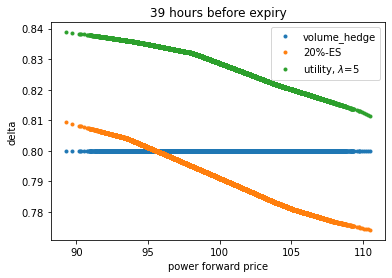

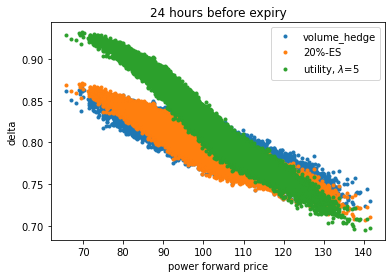

In [ ]:
for t in [9, 24, 47]:
    plt.figure()
    # volume hedge
    key = '20%-ES'
    key = labels_T[key]
    plt.plot(100*paths[key]['Power_Germany_FWD0'][t,:], paths[key]['Onshore_FWD0'][t,:],'.', label='volume_hedge', alpha=1.0)
    key = '20%-ES'
    key = labels_T[key]
    delta = -hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0'] #Power_Germany_FWD0
    plt.plot(100*v[t,:], delta,'.', label=labels[key], alpha=1.0)
    #plt.figure()
    key = 'utility, $\lambda$=5'
    key = labels_T[key]
    delta = -hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0']
    plt.plot(100*v[t,:], delta,'.', label=labels[key], alpha=1.0)
    plt.legend()
    plt.xlabel('power forward price')
    plt.ylabel('delta')
    title = str(48-t)+' hours before expiry'
    plt.title(title)
    plt.savefig('results/utility_vs_es/delta_'+str(48-t)+'.png', dpi=800)

for t in [9, 24, 47]:
    plt.figure()
    # volume hedge
    key = '20%-ES'
    key = labels_T[key]
    plt.plot(paths[key]['Onshore_FWD0'][t,:], paths[key]['Onshore_FWD0'][t,:],'.', label='volume_hedge', alpha=1.0)
    key = '20%-ES'
    key = labels_T[key]
    delta = -hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Onshore_FWD0'] #Power_Germany_FWD0
    plt.plot(v[t,:], delta,'.', label=labels[key], alpha=1.0)
    #plt.figure()
    key = 'utility, $\lambda$=5'
    key = labels_T[key]
    delta = -hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Onshore_FWD0']
    plt.plot(v[t,:], delta,'.', label=labels[key], alpha=1.0)
    plt.legend()
    plt.xlabel('onshore wind forecast')
    plt.ylabel('delta')
    title = str(48-t)+' hours before expiry'
    plt.title(title)
    plt.savefig('results/utility_vs_es/delta_onshore_'+str(48-t)+'.png', dpi=800)


### Average Delta

In [ ]:
deltas = {}
for k,v in hedge_models.items():
    #if k=='db484bd3a8c00e07e824c942ab30e2db012296f5':
    deltas[k] = hedge_models[k].compute_delta(paths[k])

Text(0, 0.5, 'delta')

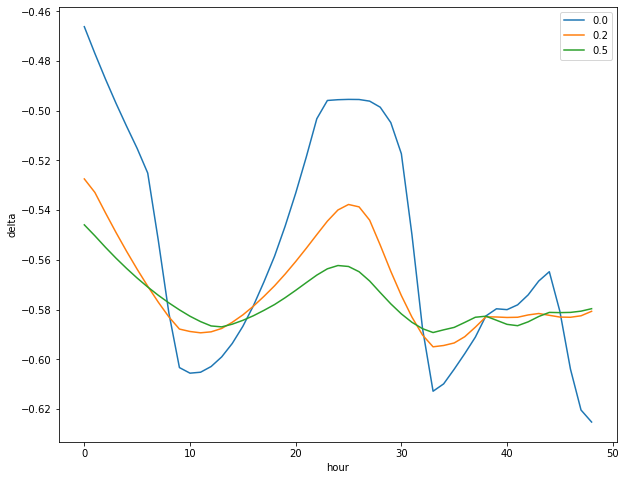

In [ ]:
plt.figure(figsize=(10,8))
for k,v in deltas.items():
    plt.plot(v.mean(axis=1), label = labels[k])
plt.legend()
plt.xlabel('hour')
plt.ylabel('delta')

In [ ]:
labels

{'35ada79703bc4f3c58b0233fcba96bbffb3f73e6': 'utility, $\\lambda$=5',
 '15cf13e7ab2152f45e1bc91214d16ca2104cef38': 'utility, $\\lambda$=10',
 'ff4d98cb75dfbaf971837f9047a61479f642cc17': '5%-ES',
 '0c7b3d8619cbec57277a6b135ab2de62bb5872d9': '20%-ES',
 'db484bd3a8c00e07e824c942ab30e2db012296f5': 'utility, $\\lambda$=20'}

In [ ]:
wind.shape

(49, 100000)

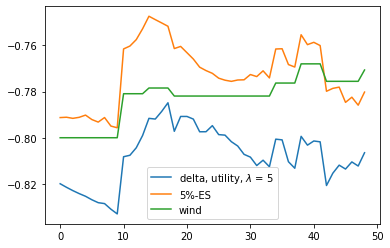

In [ ]:
k = '35ada79703bc4f3c58b0233fcba96bbffb3f73e6'
d = deltas[k]
d_es = deltas['ff4d98cb75dfbaf971837f9047a61479f642cc17']
power = paths[k]['Power_Germany_FWD0']
wind = paths[k]['Onshore_FWD0']

path = 12
plt.plot(d[:,path,0],'-', label='delta, utility, $\lambda$ = 5')
plt.plot(d_es[:,path,0],'-', label='5%-ES')
plt.plot(-wind[:,path],'-', label='wind')
plt.legend();

 Forecast = 0.8, Spot= 100, ATM, K=100
 
     | 0.7|0.8 | 0.9
 ----|----|----|----
  90 |    |    |  
  100 |   |    |
  110 |   |    |
  
  
 $p_{0.7}\cdot \left(p_{90|0.7}\cdot (\Delta(90-100)-0.7\cdot (K-90)) + p_{100|0.7}\cdot (-0.7\cdot (K-100)) 
 + p_{110|0.7}\cdot (\Delta(110-100)-0.7\cdot (K-110)\right)$

Text(0, 0.5, 'delta')

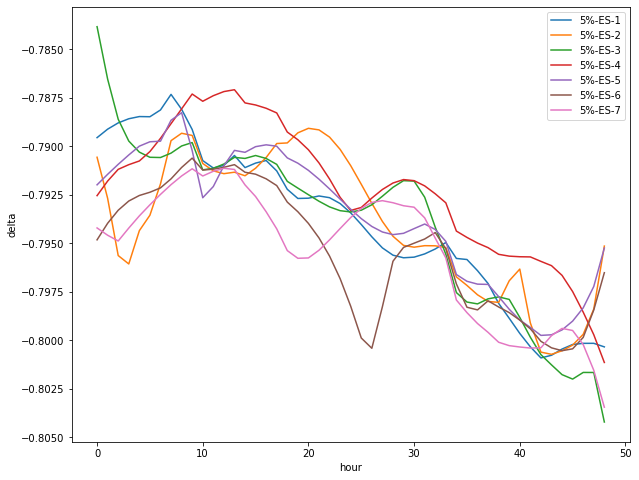

In [ ]:
plt.figure(figsize=(10,8))
for k,v in deltas.items():
    plt.plot(v.mean(axis=1), label = labels[k])
plt.legend()
plt.xlabel('hour')
plt.ylabel('delta')

Text(0.5, 0, 'delta')

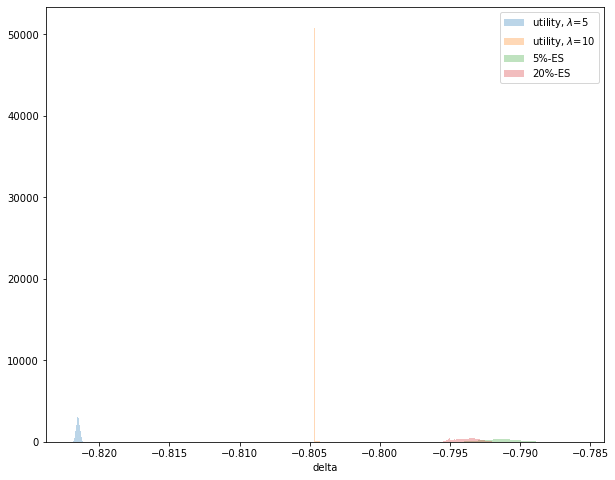

In [ ]:
plt.figure(figsize=(10,8))
for k,v in deltas.items():
    plt.hist(v[1,:], label = labels[k], alpha=0.3, bins=100, density=True)
plt.legend();
plt.xlabel('delta')


### Delta Projections

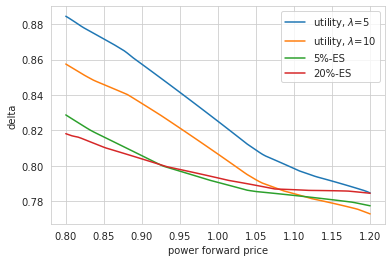

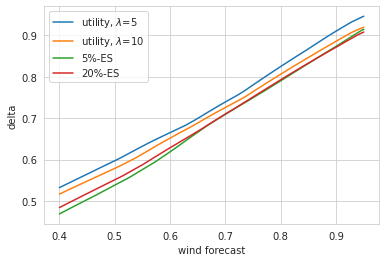

In [ ]:
for key in ['utility, $\\lambda$=5', 'utility, $\\lambda$=10', '5%-ES', '20%-ES']:
    key_ = labels_T[key]
    for t in [24]:
        power_fwd = np.linspace(0.8,1.2, 100)
        dummy_paths = {'Offshore_FWD0': np.zeros((48, power_fwd.shape[0]))}
        dummy_paths['Power_Germany_FWD0'] = np.tile(power_fwd,(48,1))
        dummy_paths['Onshore_FWD0'] = 0.8*np.ones(dummy_paths['Power_Germany_FWD0'].shape )
        delta = -hedge_models[key_].compute_delta(dummy_paths, t).reshape((-1,))
        plt.plot(power_fwd, delta, label=key)
plt.xlabel('power forward price')
plt.ylabel('delta')
plt.legend()
plt.savefig('results/utility_vs_es/delta_proj_power_24.png', dpi=800)
plt.figure()

for key in ['utility, $\\lambda$=5', 'utility, $\\lambda$=10', '5%-ES', '20%-ES']:
    key_ = labels_T[key]
    for t in [24]:
        power_fwd = np.linspace(0.4,0.95, 100)
        dummy_paths = {'Offshore_FWD0': np.zeros((48, power_fwd.shape[0]))}
        dummy_paths['Onshore_FWD0'] = np.tile(power_fwd,(48,1))
        dummy_paths['Power_Germany_FWD0'] = np.ones(dummy_paths['Offshore_FWD0'].shape )
        delta = -hedge_models[key_].compute_delta(dummy_paths, t).reshape((-1,))
        plt.plot(power_fwd, delta, label=key)
plt.xlabel('wind forecast')
plt.ylabel('delta')
plt.legend()
plt.savefig('results/utility_vs_es/delta_proj_onshore_24.png', dpi=800);

## x_volatility

In [ ]:
experiment = 'x_volatility' #'varying_regularization_forecast_0.5' #'varying_regularization' expected_shortfall
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results, forecast_points, hedge_models, specs, paths, pnl = setup(ref_keys, ref_key_volume_hedge=labels_T['0.8'])

NameError: name 'setup' is not defined

In [ ]:
repo.results['51d61a51c50178d351b6b703c9c9e7b1b5f726b0']['model']['wind_power_forecast']['region_forecast_models'][0]['model']#['volatility']

{'speed_of_mean_reversion': 0.1,
 'volatility': 3.0,
 'region': 'Onshore',
 'cls': 'WindPowerForecastModel'}

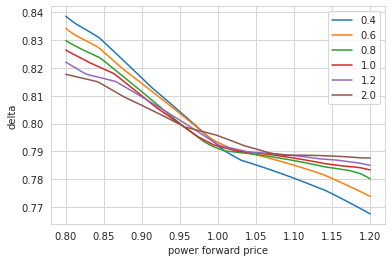

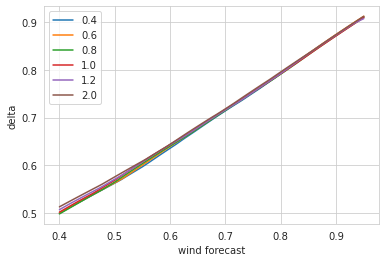

In [ ]:
for key in ['0.4', '0.6', '0.8', '1.0', '1.2', '2.0']:
    key_ = labels_T[key]
    for t in [24]:
        power_fwd = np.linspace(0.8,1.2, 100)
        dummy_paths = {'Offshore_FWD0': np.zeros((48, power_fwd.shape[0]))}
        dummy_paths['Power_Germany_FWD0'] = np.tile(power_fwd,(48,1))
        dummy_paths['Onshore_FWD0'] = 0.8*np.ones(dummy_paths['Power_Germany_FWD0'].shape )
        delta = -hedge_models[key_].compute_delta(dummy_paths, t).reshape((-1,))
        plt.plot(power_fwd, delta, label=key)
plt.xlabel('power forward price')
plt.ylabel('delta')
plt.legend()
plt.savefig('results/x_vol/delta_proj_power_24.png', dpi=800)
plt.figure()

for key in ['0.4', '0.6', '0.8', '1.0', '1.2', '2.0']:
    key_ = labels_T[key]
    for t in [24]:
        power_fwd = np.linspace(0.4,0.95, 100)
        dummy_paths = {'Offshore_FWD0': np.zeros((48, power_fwd.shape[0]))}
        dummy_paths['Onshore_FWD0'] = np.tile(power_fwd,(48,1))
        dummy_paths['Power_Germany_FWD0'] = np.ones(dummy_paths['Offshore_FWD0'].shape )
        delta = -hedge_models[key_].compute_delta(dummy_paths, t).reshape((-1,))
        plt.plot(power_fwd, delta, label=key)
plt.xlabel('wind forecast')
plt.ylabel('delta')
plt.legend();
plt.savefig('results/x_vol/delta_proj_onshore_24.png', dpi=800);

## Onshore volatility

In [ ]:
experiment = 'onshore_volatility' #'varying_regularization_forecast_0.5' #'varying_regularization' expected_shortfall
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results, forecast_points, hedge_models, specs, paths, pnl = setup(ref_keys, ref_key_volume_hedge=labels_T['1.0'])

simulate paths
load models and specs


2023-11-23 17:10:58.798849: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-23 17:10:58.798880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: moebius
2023-11-23 17:10:58.798888: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: moebius
2023-11-23 17:10:58.798953: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.78.1
2023-11-23 17:10:58.798979: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.78.1
2023-11-23 17:10:58.798986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.78.1
2023-11-23 17:10:58.799188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

compute pnl
1.0
1.0
1.0
1.0


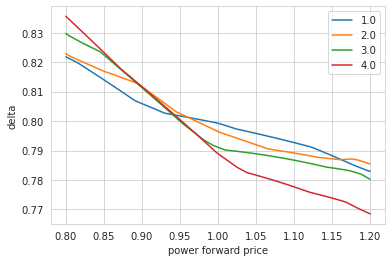

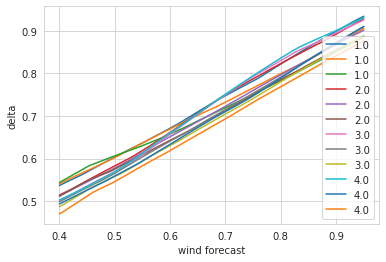

In [ ]:
for key in ['1.0', '2.0', '3.0', '4.0']:
    key_ = labels_T[key]
    for t in [24]:
        power_fwd = np.linspace(0.8,1.2, 100)
        dummy_paths = {'Offshore_FWD0': np.zeros((48, power_fwd.shape[0]))}
        dummy_paths['Power_Germany_FWD0'] = np.tile(power_fwd,(48,1))
        dummy_paths['Onshore_FWD0'] = 0.8*np.ones(dummy_paths['Power_Germany_FWD0'].shape )
        delta = -hedge_models[key_].compute_delta(dummy_paths, t).reshape((-1,))
        plt.plot(power_fwd, delta, label=key)
plt.xlabel('power forward price')
plt.ylabel('delta')
plt.legend()
plt.savefig('results/onshore_vol/delta_proj_power_24.png', dpi=800)
plt.figure()

for key in ['1.0', '2.0', '3.0', '4.0']:
    for power_fwd in [0.8,1.0,1.2]:
        key_ = labels_T[key]
        for t in [24]:
            onshore_wind = np.linspace(0.4,0.95, 100)
            dummy_paths = {'Offshore_FWD0': np.zeros((48, onshore_wind.shape[0]))}
            dummy_paths['Onshore_FWD0'] = np.tile(onshore_wind,(48,1))
            dummy_paths['Power_Germany_FWD0'] = power_fwd*np.ones(dummy_paths['Offshore_FWD0'].shape )
            delta = -hedge_models[key_].compute_delta(dummy_paths, t).reshape((-1,))
            plt.plot(onshore_wind, delta, label=key)
plt.xlabel('wind forecast')
plt.ylabel('delta')
plt.legend();
plt.savefig('results/onshore_vol/delta_proj_onshore_24.png', dpi=800);

## Utility indifference pricing

In [ ]:
experiment = 'utility pricing' #'varying_regularization_forecast_0.5' #'varying_regularization' expected_shortfall
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results, forecast_points, hedge_models, specs, paths, pnl = setup(ref_keys, ref_key_volume_hedge=labels_T['max_cap: 1.0, lambda: 5'])

simulate paths
load models and specs


2023-11-11 07:21:22.082712: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-11 07:21:22.082797: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: meray
2023-11-11 07:21:22.082819: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: meray
2023-11-11 07:21:22.082966: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.78.1
2023-11-11 07:21:22.083045: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.78.1
2023-11-11 07:21:22.083067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.78.1
2023-11-11 07:21:22.084531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfor

compute pnl
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


### Model paths

In [ ]:
sim_results['f1d004c9c43277351b00a6a91e7f4dbadd51597a'].keys()

{'Offshore_FWD0', 'Onshore_FWD0', 'Power_Germany_FWD0', 'Wind_Germany_FWD0'}

### PnL Distributions

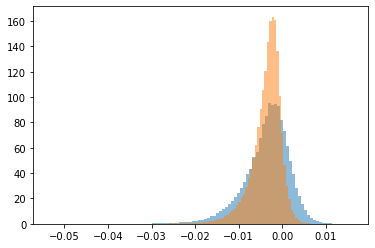

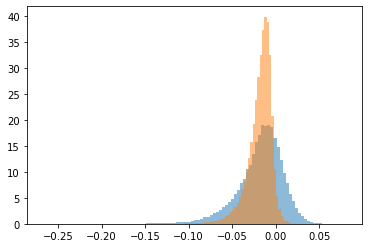

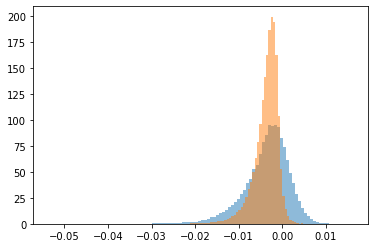

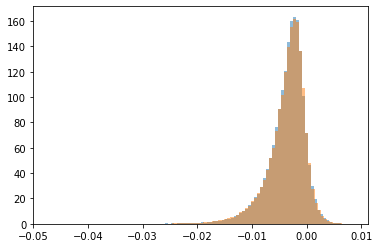

In [ ]:
key = 'max_cap: 1.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='5', density=True, alpha=0.5)
key = 'max_cap: 1.0, lambda: 10'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='10', density=True, alpha=0.5);

plt.figure()
key = 'max_cap: 1.0, lambda: 5'
key = labels_T[key]
plt.hist(5.0*pnl[key], bins=100, label='5', density=True, alpha=0.5)
key = 'max_cap: 5.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='10', density=True, alpha=0.5);

plt.figure()
key = 'max_cap: 1.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='5', density=True, alpha=0.5)
key = 'max_cap: 5.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key]/5.0, bins=100, label='10', density=True, alpha=0.5);

plt.figure()
key = 'max_cap: 1.0, lambda: 10'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='5', density=True, alpha=0.5)
key = 'max_cap: 2.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key]/2.0, bins=100, label='10', density=True, alpha=0.5);

### Price-Dependency on Maximal Capacity

In [ ]:
pnl_stat = compute_statistics(pnl, labels)

In [ ]:
prices = {'maximum capacity': [0.5,  1.0,  2.0, 5.0, 10.0]}
for l in [5, 10]:
    p = []
    p_normed = []
    i = 0
    for max_cap in prices['maximum capacity']:
        try:
            utility = pnl_stat.loc['max_cap: ' + str(max_cap)+', lambda: '+str(l), 'utility, '+ str(l/100) ]
            #utility_0 = pnl_stat.loc['max_cap: 0, lambda: '+str(l), 'utility, '+ str(l/100) ]
            p.append(np.log(utility)/(l/100))
            p_normed.append(p[-1]/max_cap)
        except:
            #print(pnl_stat.loc['max_cap: ' + str(max_cap)+', lambda: '+str(l), 'utility, '+ str(l/100) ])
            p.append(None)
    prices[l] = p
    prices[str(l) + ' normed'] =p_normed
df_prices = pd.DataFrame(prices)
df_prices

,maximum capacity,5,5 normed,10,10 normed
0,0.5,0.180799,0.361599,0.183713,0.367426
1,1.0,0.367350,0.367350,0.371599,0.371599
2,2.0,0.743211,0.371606,0.753609,0.376804
3,5.0,1.896365,0.379273,1.953677,0.390735
4,10.0,4.197502,0.419750,103.391429,10.339143


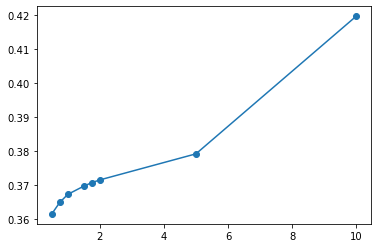

In [ ]:
plt.plot(df_prices.values[:,0], df_prices.values[:,2],'-o')
#plt.plot(df_prices.values[:,0], df_prices.values[:,2],'-o');
#plt.plot(df_prices.values[:,0], df_prices.values[:,3],'-o')
#plt.plot(df_prices.values[3][1:],'-o')


### Delta-Dependency on Maximal Capacity

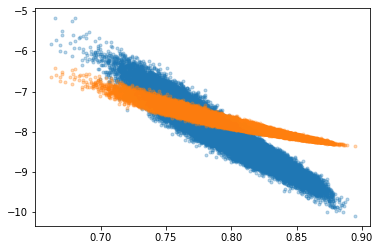

In [ ]:
t = -2
key = 'max_cap: 1.0, lambda: 5'
key = labels_T[key]
delta = hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
v = paths[key]['Onshore_FWD0'] #Power_Germany_FWD0
plt.plot(v[t,:], 10.0*delta,'.', label=labels[key], alpha=0.3)

key = 'max_cap: 10.0, lambda: 5'
key = labels_T[key]
delta = hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
v = paths[key]['Onshore_FWD0']
plt.plot(v[t,:], delta,'.', label=labels[key], alpha=0.3)


In [ ]:
paths[key].keys()

dict_keys(['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0'])

## Model paths

[datetime.datetime(2023, 1, 3, 0, 0)]
[datetime.datetime(2023, 1, 3, 0, 0)]
[datetime.datetime(2023, 1, 3, 0, 0)]


FileNotFoundError: [Errno 2] No such file or directory: 'results/onshore_forecast/paths.png'

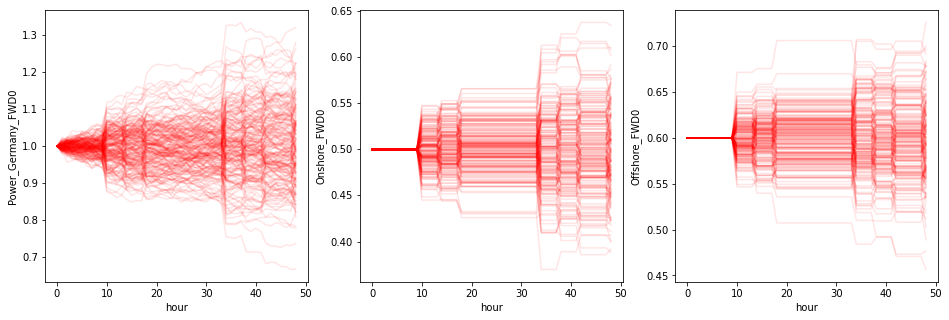

In [ ]:
sim_results ={}
forecast_points={}
for k in ref_keys:
    sim_results[k], forecast_points[k] = repo.simulate_model(k, n_sims=100_000)
    
analysis.plot_paths(sim_results[ref_keys[0]], forecast_points[ref_keys[0]], result_dir)

## Hedge PnL

In [ ]:
paths = {k:{l:sim_results[k].get(l, forecast_points[k]) for l in ['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0']} for k in ref_keys}
pnl = {
    'volume_hedge': compute_volume_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]]),
      'no_hedge': compute_no_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]]),
    'static_volume_hedge':compute_static_volume_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]])
      }
for k,v in hedge_models.items():
    paths[k]
    specs[k]
    labels[k]
    pnl[labels[k]] = compute_pnl(v, paths[k], specs[k])#specs['ec202973a34dfc5b71a86e0e7b2209a62c29b6a1'])#
#pnl['pnl_static_volume_hedge']= compute_static_volume_hedge_pnl(paths, spec)

NameError: name 'specs' is not defined

In [ ]:
if False:
    import tensorflow as tf
    model = hedge_models['24a19e98a0e338e6d0918ef48edcb1f4e00c0fd9']
    p=model._create_inputs(paths['24a19e98a0e338e6d0918ef48edcb1f4e00c0fd9'])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0)
    model.compile(optimizer, loss=model.custom_loss)
    model._loss='exponential_utility'
    model.evaluate(p, np.zeros(10_000))
    model._loss
    pred = model.predict(p)

In [ ]:
#del pnl['pnl_static_volume_hedge']
#del pnl['1.0']
#del pnl['pnl_volume_hedge']

### Statistics

In [ ]:
pnl_stat = {'name':[], 'mean': [], 'var':[],'p-skewness':[], '20%': [], '5%':[], '10%':[], '5% ES':[], '10% ES':[], '20% ES':[], 
           'utility, 0.1': [], 'utility, 0.5': []}
for k,v in pnl.items():
    if ( k == 'static_volume_hedge'):# or (k==): # (k == 'no_hedge') or
        continue
    v_ = 100.0*v
    pnl_stat['name'].append(k)
    pnl_stat['mean'].append(np.mean(v_))
    pnl_stat['var'].append(np.sqrt(np.var(v_)))
    pnl_stat['p-skewness'].append( 3.0*(v_.mean()-np.median(v_))/v_.std())
    
    tmp = np.percentile(v_, 10)
    pnl_stat['10%'].append(tmp)
    tmp = v_[v_<tmp].mean()
    pnl_stat['10% ES'].append(tmp) 
    
    tmp = np.percentile(v_, 20)
    pnl_stat['20%'].append(tmp)
    tmp = v_[v_<tmp].mean()
    pnl_stat['20% ES'].append(tmp)
    tmp = np.percentile(v_, 5)
    pnl_stat['5%'].append(tmp)
    tmp = v_[v_<tmp].mean()
    pnl_stat['5% ES'].append(tmp)
    
    pnl_stat['utility, 0.1'].append(np.mean(np.exp(-0.1*v_)))
    pnl_stat['utility, 0.5'].append( np.mean(np.exp(-0.5*v_)))
    
pnl_stat = pd.DataFrame(pnl_stat)
pnl_stat#.to_latex(float_format="{:0.3f}".format)

,name,mean,var,p-skewness,20%,5%,10%,5% ES,10% ES,20% ES,"utility, 0.1","utility, 0.5"
0,volume_hedge,-0.367972,0.380545,-0.880494,-0.543914,-1.087128,-0.803198,-1.565406,-1.246482,-0.951698,1.038265,1.229867
1,no_hedge,-0.613481,11.250506,0.097671,-10.049430,-18.580167,-14.756735,-22.875742,-19.685455,-15.947874,1.930105,144680.952623
2,"utility, 10",-0.367114,0.330088,-0.595768,-0.567506,-0.976964,-0.771549,-1.308181,-1.084684,-0.870992,1.037969,1.219771
3,"utility, 20",-0.368530,0.292894,-0.597649,-0.551582,-0.909428,-0.729048,-1.198061,-1.003232,-0.816547,1.037993,1.216538
4,"utility, 50",-0.367361,0.304593,-0.597390,-0.555252,-0.928598,-0.739519,-1.237868,-1.030689,-0.833702,1.037909,1.217119


In [ ]:
np.log(1.217119)/0.5
np.log(1.037969)/0.1

0.37265919172484235

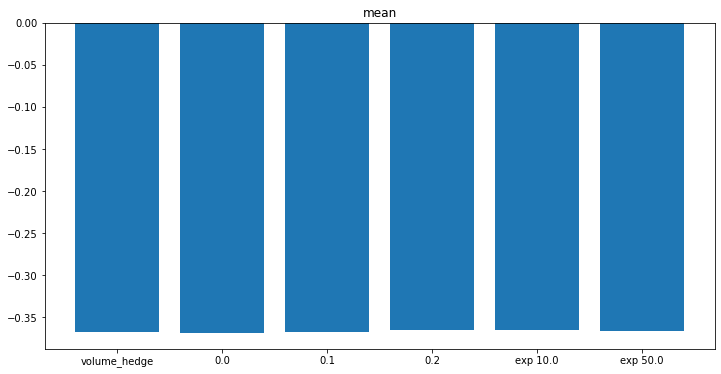

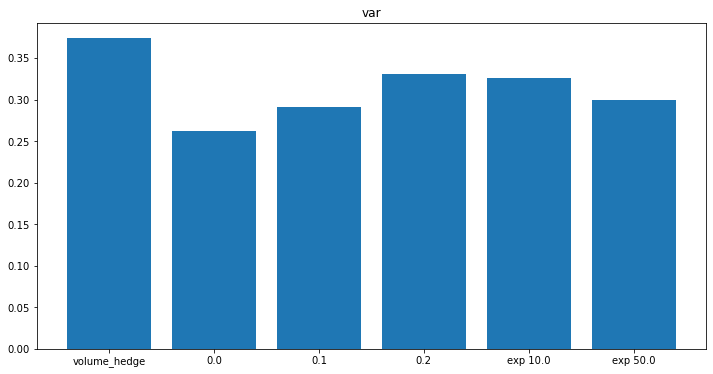

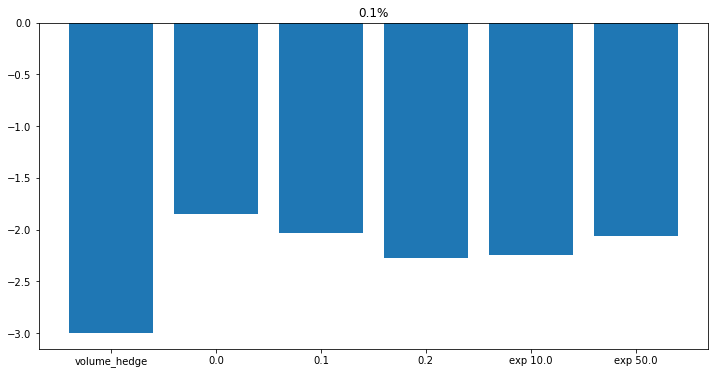

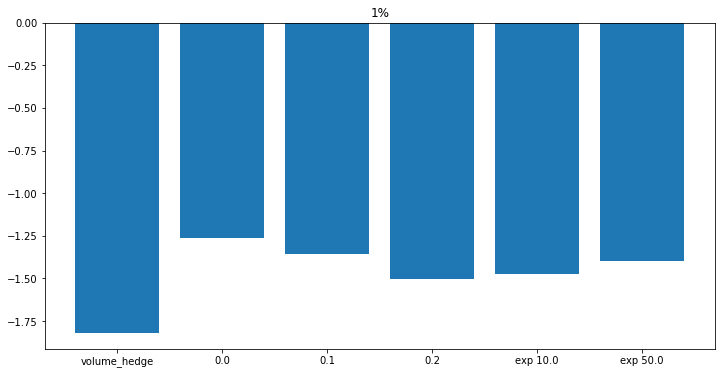

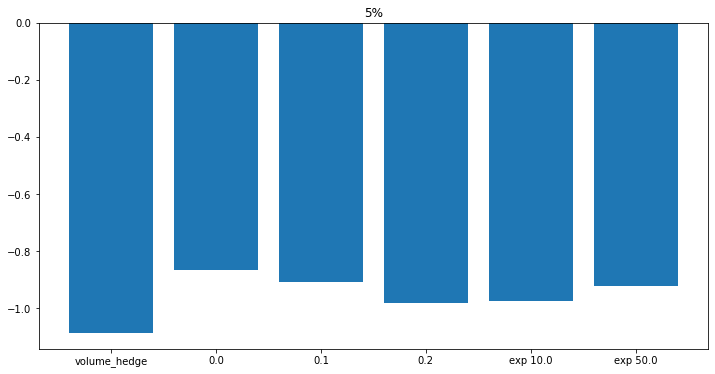

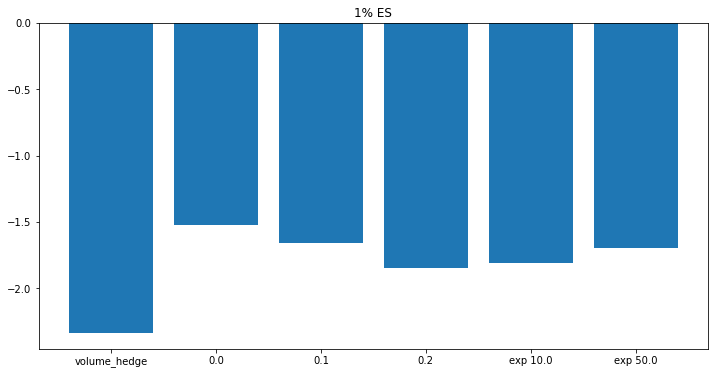

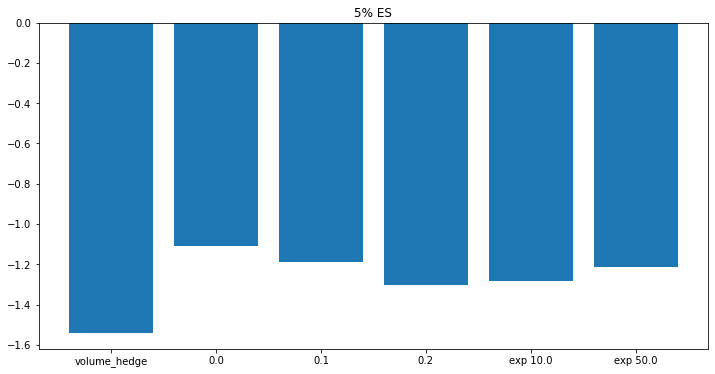

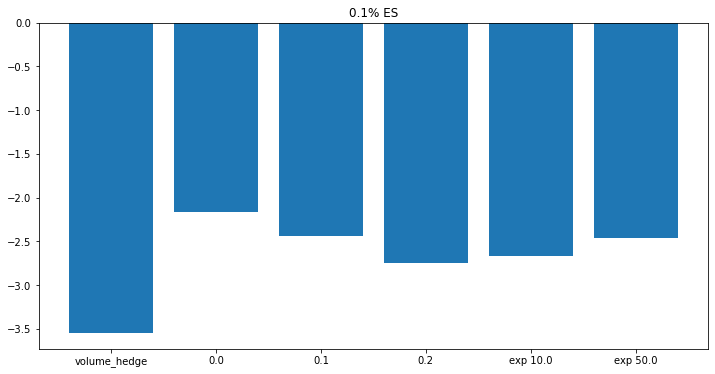

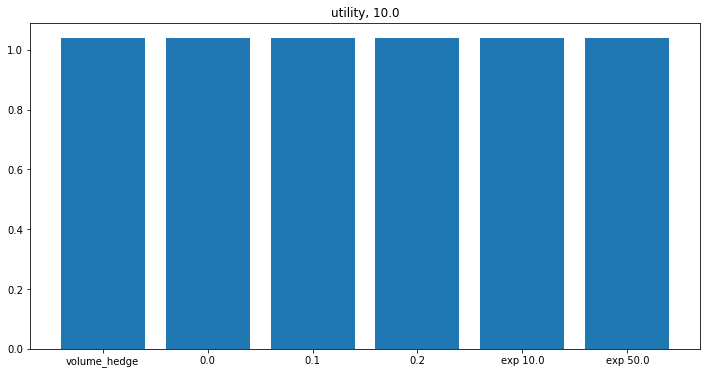

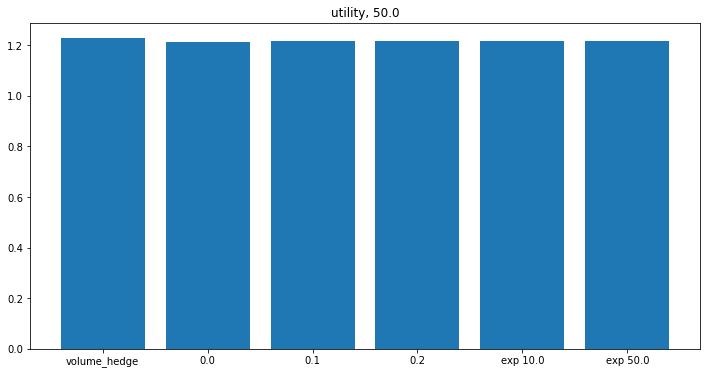

In [ ]:
for k in pnl_stat.columns:
    if k == 'name':
        continue
    names = list(pnl_stat['name'])
    values = list(pnl_stat[k])
    plt.figure(figsize=(12,6))
    plt.title(k)
    plt.bar(range(len(names)), values, tick_label=names);

### Distribution

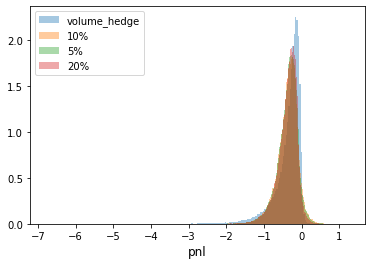

In [ ]:
#plt.figure(figsize=(15,8))
alpha = 0.4#1.0/len(pnl)
#plt.hist(pnl_volume_hedge,bins=100, label='volume hedge', alpha=alpha, density=True)

order = []
for k,v in pnl.items():
    order.append((np.var(v),k))
    
order.sort(reverse=True)
order = [k[1] for k in order]
ignored = ['no_hedge', 
           'static_volume_hedge',
           #'volume_hedge',
           #'0.2',
           '0.5',
           #'0.8',
           #'volume_hedge',
           #'0.1',
           #'0.2',
           'utility, 10',
           'utility, 50',
           #'0.0'
          ]
for k in order:
    if k in ignored:
        continue
    pnl_= pnl[k]#pnl[k] #np.clip(pnl[k], -0.005,0.005)
    plt.hist(100*pnl_,bins=200, label=k, alpha=alpha, density=True)#,  histtype='step')
plt.legend()
#plt.xlim(-3,2.0)
plt.xlabel('pnl', fontsize=12);
plt.savefig(result_dir+'pnl_distributions.png', dpi=400)

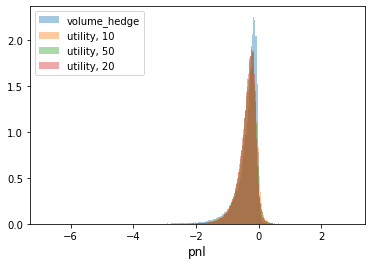

In [ ]:
#plt.figure(figsize=(15,8))
alpha = 0.4#1.0/len(pnl)
#plt.hist(pnl_volume_hedge,bins=100, label='volume hedge', alpha=alpha, density=True)

order = []
for k,v in pnl.items():
    order.append((np.var(v),k))
    
order.sort(reverse=True)
order = [k[1] for k in order]
ignored = ['no_hedge', 
           'static_volume_hedge',
           #'volume_hedge',
           #'0.2',
           '0.5',
           #'0.8',
           #'volume_hedge',
           #'0.1',
           #'0.2',
           'utility, 20'
           #'utility, 10',
           'utility, 50',
           #'0.0'
          ]
for k in order:
    if k in ignored:
        continue
    pnl_= pnl[k]#pnl[k] #np.clip(pnl[k], -0.005,0.005)
    plt.hist(100*pnl_,bins=200, label=k, alpha=alpha, density=True)#,  histtype='step')
plt.legend()
#plt.xlim(-3,2.0)
plt.xlabel('pnl', fontsize=12);
plt.savefig(result_dir+'pnl_distributions.png', dpi=400)

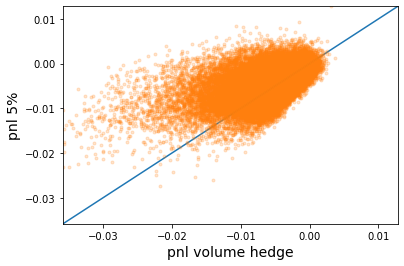

In [ ]:
key = '5%' #'0.0'
pnl_min = np.min(pnl[key])
pnl_max = np.max(pnl[key])

plt.plot([pnl_min,pnl_max], [pnl_min,pnl_max], '-')
plt.plot(pnl['volume_hedge'], pnl[key],'.', alpha=0.2)

plt.xlim(pnl_min, pnl_max)
plt.ylim(pnl_min, pnl_max)
plt.xlabel('pnl volume hedge', fontsize=14)
plt.ylabel('pnl '+key, fontsize=14);
plt.savefig(result_dir+'pnl_comparison_scatter.png', dpi=400)

### Dependencies

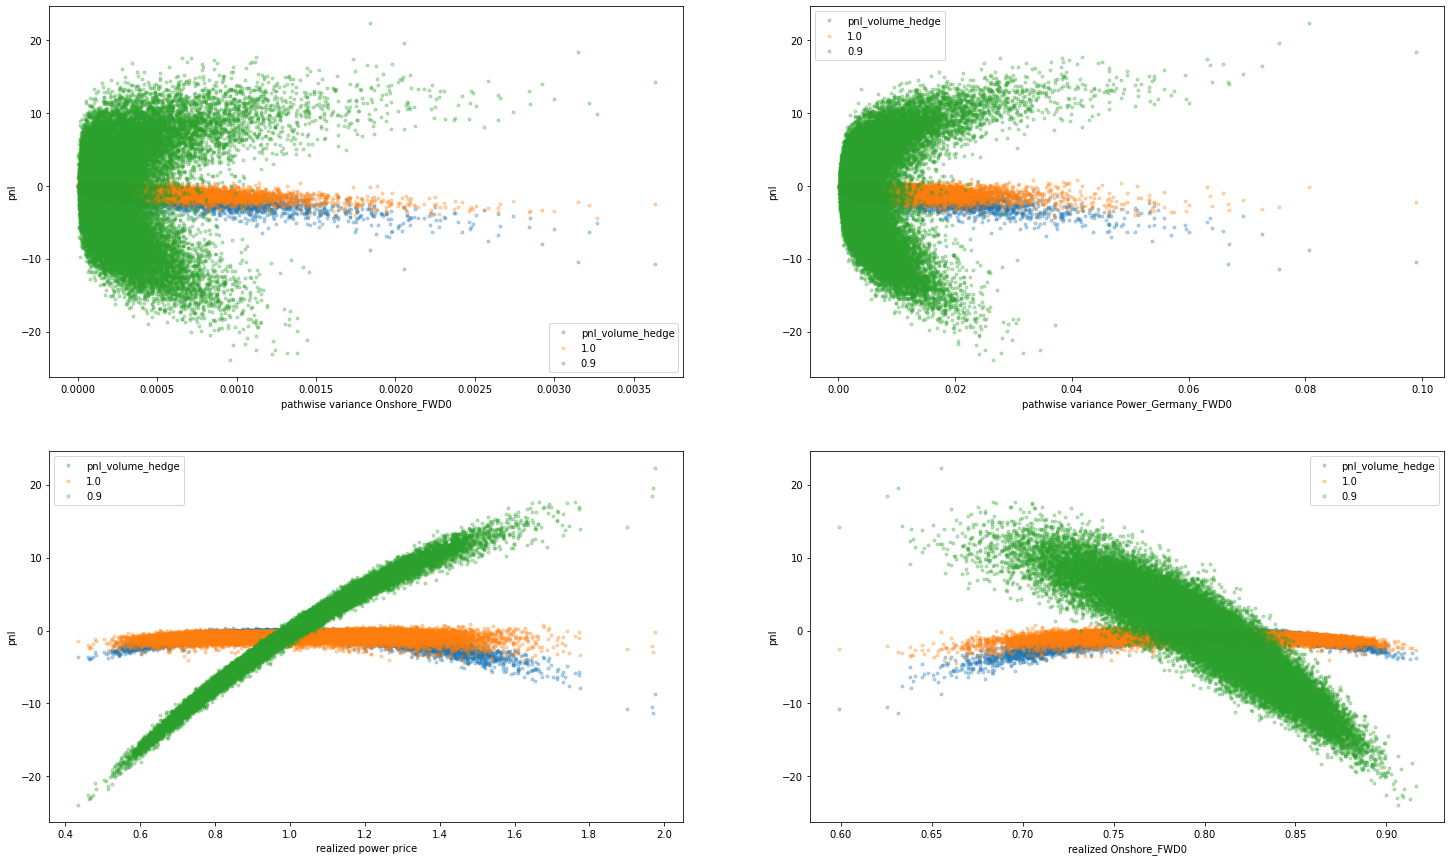

In [ ]:
plt.figure(figsize=(25,15))

power_price = paths.get('Power_Germany_FWD0', None)
volume = paths.get(spec.location+'_FWD0')
volume_var = volume.var(axis=0)
plt.subplot(2,2,1)
#plt.hist(volume_var, bins=100, density=True);
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(volume_var, 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('pathwise variance Onshore_FWD0')

plt.subplot(2,2,2)
power_var = power_price.var(axis=0)
#plt.hist(volume_var, bins=100, density=True);
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(power_var, 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('pathwise variance Power_Germany_FWD0');

plt.subplot(2,2,3)
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(power_price[-1,:], 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('realized power price');

plt.subplot(2,2,4)
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(volume[-1,:], 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('realized Onshore_FWD0');
plt.savefig(result_dir+'pnl_vs_paths.png', dpi=400)

In [ ]:
hedge_models.items()

dict_items([('7525471af6019d720fe596c36a689a8bcbaf6c3b', <rivapy.pricing.deep_hedging.DeepHedgeModel object at 0x7f3992178d00>)])

## Delta Plots

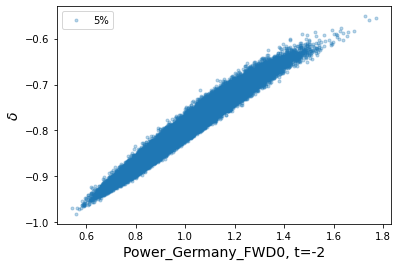

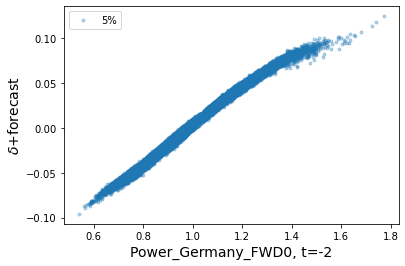

In [ ]:
t = -2
n_x = 1
n_y = 3

#plt.figure(figsize=(24,8))
volume_hedge=-1.0*paths[ref_keys[0]]['Onshore_FWD0'][t,:]
for k in ['5%',
          #'0.1',
         # '0.0'
         ]:
    key = labels_T[k]
    hedge_model = hedge_models[key]

    #plt.figure(figsize=(24,8))
    #if labels[key] in ['1.0','0.5']:
    #    continue
    delta = hedge_model.compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0']
    plt.plot(v[t,:], delta,'.', label=labels[key], alpha=0.3)#+paths[key]['Onshore_FWD0'][t,:]
    plt.xlabel('Power_Germany_FWD0'+', t='+str(t), fontsize=14)
    plt.ylabel('$\delta$', fontsize=14)
plt.legend()
plt.savefig(result_dir+'delta_vs_power'+str(t)+'.png', dpi=400)
plt.figure()
for k in ['5%',#'0.1',
         # '0.0'
         ]:
    key = labels_T[k]
    hedge_model = hedge_models[key]

    #plt.figure(figsize=(24,8))
    #if labels[key] in ['1.0','0.5']:
    #    continue
    delta = hedge_model.compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0']
    plt.plot(v[t,:], delta+paths[key]['Onshore_FWD0'][t,:],'.', label=labels[key], alpha=0.3)#
    plt.xlabel('Power_Germany_FWD0'+', t='+str(t), fontsize=14)
    plt.ylabel('$\delta$+forecast', fontsize=14)
plt.legend()
plt.savefig(result_dir+'delta_diff_vs_power'+str(t)+'.png', dpi=400);


In [ ]:
if False:
    t = -2
    n_x = 1
    n_y = 3
    ignored = ['no_hedge', 
               'static_volume_hedge',
               '0.5',
               #'volume_hedge',
               '0.1',
               '0.2',
               'exp 10.0',
               'exp 50.0',
               #'0.0'
              ]
    #plt.figure(figsize=(24,8))
    volume_hedge=-1.0*paths[ref_keys[0]]['Onshore_FWD0'][t,:]
    plot_volume_hedge = True
    for key, hedge_model in hedge_models.items():
        if labels[key] in ignored:
            continue
        #plt.figure(figsize=(24,8))
        #if labels[key] in ['1.0','0.5']:
        #    continue
        delta = hedge_model.compute_delta(paths[key], t).reshape((-1,))
        i=1

        for k,v in paths[key].items():
            plt.figure()
            #plt.subplot(n_x, n_y, i)
            plt.plot(v[t,:], delta+paths[key]['Onshore_FWD0'][t,:],'.', label=labels[key], alpha=0.3)
            #if plot_volume_hedge and True:
            #    plt.plot(v[t,:], volume_hedge, '.', label='volume hedge', alpha=0.3)
            if k == 'Onshore_FWD0':
                plt.plot([0.6,0.95],[-0.6,-0.95])
            plt.xlabel(k+', t='+str(t))
            plt.ylabel('delta')
            plt.legend()
            i+= 1
        plot_volume_hedge = False

    plt.legend()
    #plt.savefig(result_dir+'delta_'+str(t)+'.png', dpi=400)
    if False:
        for k,v in paths.items():
            plt.subplot(n_x, n_y, i)
            plt.plot(v[t,:], v[-1,:],'.')
            plt.xlabel(k+', t='+str(t))
            plt.ylabel(k+', final')
            i+= 1

In [ ]:
delta = {'volume hedge': -paths[ref_keys[0]].get('Onshore_FWD0')}
for key, hedge_model in hedge_models.items():
    d = hedge_model.compute_delta(paths[key])
    delta[labels[key]] = d.reshape((d.shape[0],-1))

In [ ]:
key = '5%'
paths[ref_keys[0]].get('Power_Germany_FWD0')
pnl_diff = pnl[key] - pnl['volume_hedge']
plt.plot(power[-1,:], pnl_diff, '.', alpha=0.1)
plt.xlabel('final power price')
plt.ylabel('pnl difference')
plt.axhline(0.0, color='r')
plt.savefig(result_dir+'power_price_vs_pnl_dif'+str(t)+'.png', dpi=400);
plt.figure()
wind = paths[ref_keys[0]].get('Onshore_FWD0')
pnl_diff = pnl[key] - pnl['volume_hedge']
plt.plot(wind[-1,:], pnl_diff, '.', alpha=0.1)
plt.xlabel('final wind')
plt.ylabel('pnl difference')
plt.axhline(0.0, color='r')
plt.savefig(result_dir+'wind_vs_pnl_dif'+str(t)+'.png', dpi=400);

NameError: name 'power' is not defined

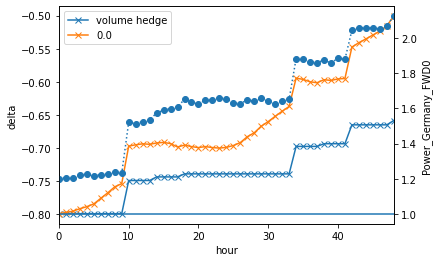

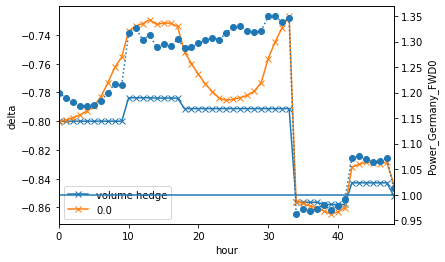

In [ ]:
pnl_diff = pnl['0.0'] - pnl['volume_hedge']
n_paths = [(np.argmax(pnl_diff), 'max_pnl_diff'), (np.argmin(pnl_diff), 'min_pnl_diff')]
ignore = ['0.2', '0.5']
for n_path, n_path_name in n_paths:
    plt.figure()
    #plt.figure(figsize=(10,8))
    for k,v in delta.items():
        if k in ignore:
            continue
        plt.plot(v[:,n_path], '-x', label=k)
    plt.legend()  
    plt.ylabel('delta')
    plt.xlabel('hour'); 
    ax2 = plt.twinx() 
    power = paths[ref_keys[0]].get('Power_Germany_FWD0')
    ax2.plot(power[:,n_path],':o')
    ax2.set_ylabel('Power_Germany_FWD0')
    ax2.axhline(1.0)
    plt.xlim(0,48);
    plt.savefig(result_dir+'delta_path_'+n_path_name+'.png', dpi=400);

In [ ]:
result_dir

'results/varying_regularization_ITM/'